### EXP: Pilote2 QC rating 

- **Aim:** Test reliability of quality control (QC) of brain registration ratings between two experts raters (PB: Pierre Bellec, YB: Yassine Benahajali) based on the first drafted qc protocol on the zooniverse platform ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 50 anatomical brain images (16 OK, 17 Maybe and 17 Fail)   preprocced with NIAK pipelines from ADHD200 datsets.
    - Each rater (PB and YB) rated (OK, Maybe or Fail) Zooniverse platform interface.

In [126]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [127]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [128]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [129]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [130]:
# Filter out only specific workflow
ratings = classifications.loc[classifications['workflow_name'].isin(['anat_internal_rating_pierre',
                                                                     'anat_internal_rating_yassine'])]
ratings.count()

classification_id    129
user_name            129
user_id              129
user_ip              129
workflow_id          129
workflow_name        129
workflow_version     129
created_at           129
gold_standard          0
expert                 0
metadata             129
annotations          129
subject_data         129
subject_ids          129
dtype: int64

In [131]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[1]['value']) for q in ratings.annotations]
# extract rating count
ratings.loc[:,"rating"] = [ q[0]['value'] for q in ratings.annotations]
# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids[ind])]['subject_ID'] for ind,row in ratings.iterrows()]
# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids[ind])]['images'] for ind,row in ratings.iterrows()]

In [132]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count

Yassinebha    75
simexp        54
Name: user_name, dtype: int64

In [133]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

simexp have 4 duplicated ratings
Yassinebha have 25 duplicated ratings
Total number of duplicated ratings  = 29


In [134]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

simexp        50
Yassinebha    50
Name: user_name, dtype: int64

In [135]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.rename(columns={'simexp':'PB','Yassinebha':'YB'},inplace=True)
df_ratings.head()

,ID,PB,YB
0,X3160561,Maybe,Maybe
1,X3848511,Maybe,Maybe
2,X3163200,Maybe,OK
3,X2081148,Maybe,Maybe
4,X0021046,Fail,Fail


In [136]:
# Import rating from Pilot1
ratings_p1 = pd.read_csv('../data/rating/Pilot_QC_Pierre_Yassine-12-10-2018.csv').rename(index=str, columns={"status_Athena": "PB_Athena", "status_NIAK": "PB_NIAK",
                                   "status_Athena.1": "YB_Athena", "status_NIAK.1": "YB_NIAK"})
ratings_p1 = ratings_p1[['id_subject','PB_NIAK','YB_NIAK']].rename(columns={'id_subject':'ID','PB_NIAK':'PB_P1','YB_NIAK':'YB_P1'})
ratings_p1.head()

,ID,PB_P1,YB_P1
0,X0026001,Maybe,Maybe
1,X0026002,Maybe,Maybe
2,X0026004,Maybe,Maybe
3,X0026005,Maybe,Maybe
4,X0026009,Maybe,Maybe


In [137]:
# Merge Pilot1 and 2 
ratings_p1p2= pd.merge(df_ratings,ratings_p1,how='inner',on='ID').rename(columns={"PB": "PB_P2", "YB": "YB_P2"}).apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [138]:
ratings_p1p2.head()

,ID,PB_P2,YB_P2,PB_P1,YB_P1
0,X3160561,Maybe,Maybe,Maybe,OK
1,X2081148,Maybe,Maybe,Maybe,OK
2,X0026039,OK,Maybe,Maybe,Maybe
3,X0010054,OK,OK,OK,OK
4,X4362730,Maybe,Maybe,Maybe,Maybe


In [139]:
# Save a copy on the disk
df_ratings.to_csv('../data/rating/Pilot2_internal_rating-PB_YB.csv',index=False)
ratings_p1p2.to_csv('../data/rating/Pilot1-2_internal_rating-PB_YB.csv',index=False)

### Kappa for Pilote 2 only

In [140]:
# Add matching column between the raters
df_ratings.loc[:,"rating_match"] = df_ratings.loc[:,['PB','YB']].apply(lambda x: len(set(x)) == 1, axis=1)
df_ratings.head()

,ID,PB,YB,rating_match
0,X3160561,Maybe,Maybe,True
1,X3848511,Maybe,Maybe,True
2,X3163200,Maybe,OK,False
3,X2081148,Maybe,Maybe,True
4,X0021046,Fail,Fail,True


In [141]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
df_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)

df_ratings.head()

,ID,PB,YB,rating_match
0,X3160561,2,2,True
1,X3848511,2,2,True
2,X3163200,2,1,False
3,X2081148,2,2,True
4,X0021046,3,3,True


In [142]:
# calculate the percentage of agreement  between raters
agreem_ = (df_ratings.rating_match.sum()/df_ratings.ID.count())*100
print("The percentage of agreement is: {:.2f}".format(agreem_))

The percentage of agreement is: 72.00


In [143]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [144]:
# Percenteage of agrrement between raters with R package IRR
agree_ = df_ratings[['PB','YB']]
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 50 
   Raters = 2 
  %-agree = 72 



In [147]:
# FDR correction
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = False):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50 for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [148]:
# Kappa calculation
def kappa_score(k_df,log10 = False):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
            
    # FDR Correction       
    p_store = fdr_transf(p_store,log10)
    return k_store, p_store

In [149]:
# Get Kappa score out of all different combination of ratings
kappa_df  = df_ratings[['PB','YB']]
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.64 , std : 0.00

 Fleiss' Kappa for m Raters

 Subjects = 50 
   Raters = 2 
    Kappa = 0.559 

        z = 5.5 
  p-value = 3.85e-08 



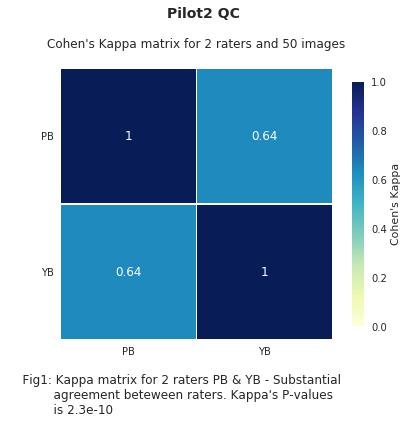

In [150]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for 2 raters and {} images".format(len(df_ratings)),pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 2 raters PB & YB - Substantial
            agreement beteween raters. Kappa's P-values
            is {:.2g} '''.format(pval)
f.text(.1,-0.08,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/pilot2_qc.svg')

In [151]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Kappa between pilot 1 and 2 

In [152]:
# Add matching column between the raters
ratings_p1p2.loc[:,"rating_match"] = ratings_p1p2.loc[:,['PB_P1','YB_P1','PB_P2','YB_P2']].apply(lambda x: len(set(x)) == 1, axis=1)
ratings_p1p2.head()

,ID,PB_P2,YB_P2,PB_P1,YB_P1,rating_match
0,X3160561,Maybe,Maybe,Maybe,OK,False
1,X2081148,Maybe,Maybe,Maybe,OK,False
2,X0026039,OK,Maybe,Maybe,Maybe,False
3,X0010054,OK,OK,OK,OK,True
4,X4362730,Maybe,Maybe,Maybe,Maybe,True


In [153]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
ratings_p1p2.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)

ratings_p1p2.head()

,ID,PB_P2,YB_P2,PB_P1,YB_P1,rating_match
0,X3160561,2,2,2,1,False
1,X2081148,2,2,2,1,False
2,X0026039,1,2,2,2,False
3,X0010054,1,1,1,1,True
4,X4362730,2,2,2,2,True


In [154]:
# calculate the percentage of agreement  between raters
agreem_ = (ratings_p1p2.rating_match.sum()/ratings_p1p2.ID.count())*100
print("The percentage of agreement is: {:.2f}".format(agreem_))

The percentage of agreement is: 60.00


In [155]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [156]:
# Percenteage of agrrement between raters with R package IRR
agree_ = ratings_p1p2[['PB_P2','YB_P2','PB_P1','YB_P1']]
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 30 
   Raters = 4 
  %-agree = 60 



In [157]:
# Get Kappa score out of all different combination of ratings
kappa_df  = ratings_p1p2[['PB_P2','YB_P2','PB_P1','YB_P1']]
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.64 , std : 0.08

 Fleiss' Kappa for m Raters

 Subjects = 30 
   Raters = 4 
    Kappa = 0.62 

        z = 11.4 
  p-value = 0 



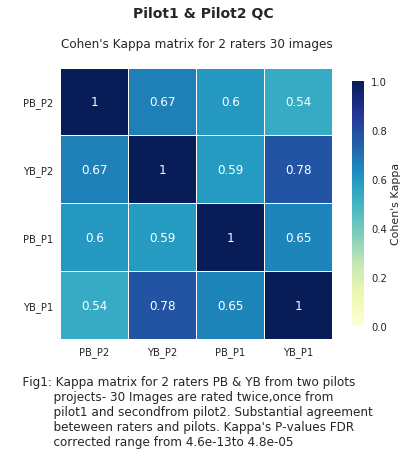

In [160]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot1 & Pilot2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for 2 raters {} images".format(len(ratings_p1p2)),pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 2 raters PB & YB from two pilots 
            projects- {} Images are rated twice,once from 
            pilot1 and secondfrom pilot2. Substantial agreement
            beteween raters and pilots. Kappa's P-values FDR
            corrected range from {:.2g}to {:.2g} '''.format(len(ratings_p1p2),Pval_store.min(), Pval_store.max())
f.text(.1,-0.17,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/pilot2_qc.svg')

### Report tagging 

In [161]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[1]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.user_name.replace({'simexp':'PB','Yassinebha':'YB'},inplace=True)
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X3160561,anat_internal_rating_pierre,PB,Maybe,217.260406,182.0,1.5,2,summary_X3160561_anat2template.gif,0
1,X3160561,anat_internal_rating_pierre,PB,Maybe,64.260406,322.0,1.5,2,summary_X3160561_anat2template.gif,0
2,X3848511,anat_internal_rating_pierre,PB,Maybe,81.260406,326.0,1.5,1,summary_X3848511_anat2template.gif,0
3,X3163200,anat_internal_rating_pierre,PB,Maybe,32.260406,396.0,1.5,1,summary_X3163200_anat2template.gif,0
4,X2081148,anat_internal_rating_pierre,PB,Maybe,29.260406,252.0,1.5,1,summary_X2081148_anat2template.gif,0


In [162]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm.head()

,ID,imgnm
0,X0010003,summary_X0010003_anat2template.gif
1,X0010007,summary_X0010007_anat2template.gif
2,X0010009,summary_X0010009_anat2template.gif
3,X0010013,summary_X0010013_anat2template.gif
4,X0010032,summary_X0010032_anat2template.gif


In [163]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)


coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [164]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))
colors_tagger

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

### Plot tagging per rater

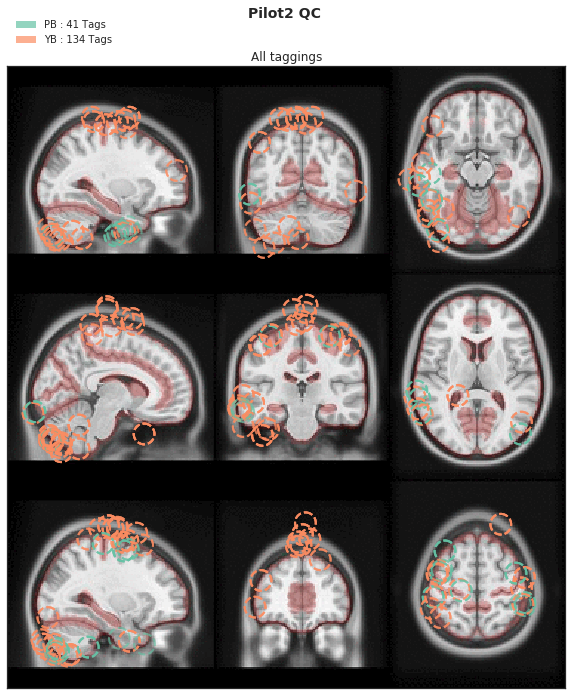

In [165]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Arrow

#Set Template image as background
fig = plt.figure(figsize=(10,14))
ax = fig.add_subplot(111)
im = plt.imread('../data/Misc/template_stereotaxic_v1.png')
ax.set_title('All taggings')
ax.imshow(im)
fig.suptitle('Pilot2 QC',x=0.51,y=.87, fontsize=14, fontweight='bold')
# Plot tags
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches = []
    labels = []
    for ind,row in out_tmp.iterrows():
        for idx,tagger in enumerate(list_tagger):
            out_tagger = out_tmp[out_tmp['user_name'] == tagger]
            c = [Circle((rowtag.x,rowtag.y), 7) 
                 for itag,rowtag in out_tagger.iterrows()]
            p =  PatchCollection(c,facecolor='none', 
                                edgecolor=colors_tagger[idx], 
                                alpha=0.4,
                                linewidth=2,
                                linestyle='dashed')
            ax.add_collection(p)
            
    #Set figure Tags labels       
    tag_ = np.zeros((len(df_ids_imgnm),len(list_tagger)))
    l = list()
    labels = list()
    for ind, row in df_ids_imgnm.iterrows():
        out_tmp = out_tag[out_tag['ID'] == row.ID]
        patches = []
        labels = []
        tag_[ind,:]= [sum(out_tmp[out_tmp['user_name'] == rater].n_tagging.unique()) 
                         for rater in list_tagger]

    for rater_id, rater in enumerate(list_tagger):
        l.append(Circle((None,None), facecolor=colors_tagger[rater_id], alpha=0.7))
        labels.append('{} : {:g} Tags'.format(rater,tag_.sum(axis=0)[rater_id]))
        
ax.legend(handles=l,labels=labels, 
          bbox_to_anchor=(0., 1.02, 1., .2), 
          mode='expand', ncol=1, loc="lower right")
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.savefig('../reports/figures/pilot2_qc_tags.svg')

### Plot heat map for all tagging

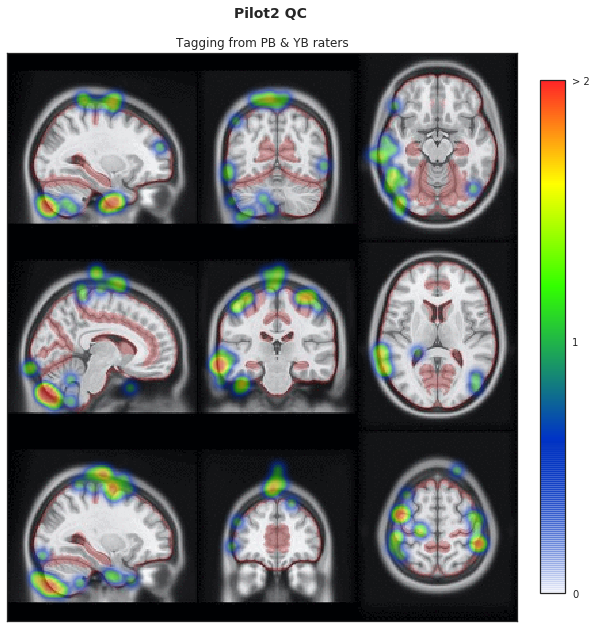

In [167]:
from heatmappy import Heatmapper
from PIL import Image

patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Pilot2 QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v1.png')
axes.set_title('Tagging from PB & YB raters')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=20,
                        point_strength = 0.5,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '1', '> 2'])

img.close()
heatmap.close()
f.savefig('../reports/figures/pilot2_qc_heatmap_tags.svg')